# (5) First inference on Lineage 1.

## Data preparation for inference. 

In this notebook we aim to utilise the code from notebooks 1-4 to do our first SMC-ABC inference on the data. Let's import all the necessary data and format it. First let's import the SSA and generation extracting modules.

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;

Import the raw data and import some more packages.

In [2]:
using DelimitedFiles;
using Distributions;

In [3]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

Take the raw data for lineage fluorescence and volume, then separate each lineage into generations.

In [6]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

Read in the proportionality constants for the molecule number and the exponential growth rates for each generation.

In [7]:
fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

Now find the molecule number for each timepoint using the proportionality constants and the lineage fluorescence data.

In [8]:
num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

Create the 2-d array storing the non-inferred parameters to be used in the used in the SSA simulations.

In [10]:
v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## Algorithm set-up for package GpABC

Create a `Single_lin` function as in notebook 4 that outputs SSA data for each lineage for a given set of ABC parameters. Note that the form of the outputed data (`Array{Float64,2}`) is such that it can be used in the simulator function for the `SimulatedABCSMC` method of the GpABC package.

In [11]:
function Single_lin(lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, ssa[1]); append!(SSA_data_c, ssa[2]); append!(SSA_data_v, ssa[3]);
    end
    return convert(Array{Float64,2},transpose(SSA_data_n)), convert(Array{Float64,2},transpose(SSA_data_c)), SSA_data_v # return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

Produce a sample run of the the lineage simulator and take a look.

In [12]:
# Sample run
single = @time Single_lin(num_sep_all_lins[1], [-1,0.5,1,0.5], v0_n0_th[1]); # do for first gen.

  0.273817 seconds (549.51 k allocations: 28.224 MiB, 3.01% gc time)


In [13]:
single[1];

Form the `simulator_function_conc` that provides the simulator specified in the GpABC package for inference on the *protein concentrations.*

In [14]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params)
    lin_conc = Single_lin(lineage_data, var_params, lin_ic)[2]
    return lin_conc
end

simulator_function_conc (generic function with 1 method)

Import GpABC and other required packages.

In [15]:
using GpABC, LambertW, Distances, Plots; pyplot();

Start the inference:
- (1) `n_particles` gives the number of accepted ABC parameter sets for each step in the threshold simulator.
- (2) `threshold_schedule` gives the different thresholds for the SMC-ABC inference.
- (3) `reference_data_c` is the concentration data for the first 69 generations in lineage 1.
- (4) `priors` is the array containing the priors on each inferred parameter (chosen to be uniform).

┌ Info: GpABC rejection simulation. ϵ = 5000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 2500.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 1250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 57/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 126/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 188/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 1000.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 109/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC si

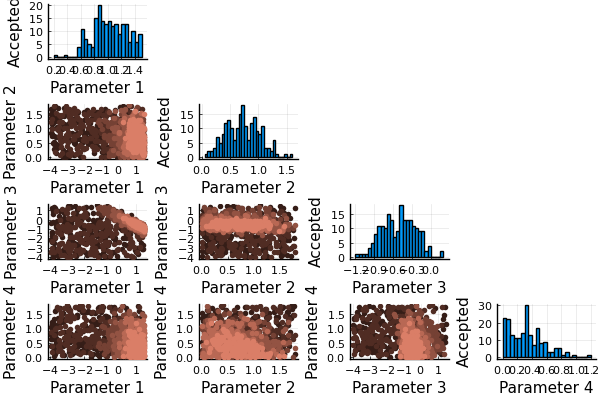

In [81]:
n_particles = 200;
threshold_schedule = [5000.0, 2500.0, 1250.0, 1000.0, 750.0, 500.0];
reference_data_c = conc_all_lins[1][1:length(single[2])];
ref_data_form = convert(Array{Float64,2},transpose(reference_data_c)); # convert ref data to the correct form.

priors = [Uniform(-4.0, 1.5), Uniform(0.0, 1.8), Uniform(-4.0, 1.5),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(ref_data_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67"]#,"#E57053","#E75935"]#,"#E84D26","#E84117"]#,"#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

Store the median values from the final posteriors in order $\{\alpha_0,\alpha_1,\beta_0,\beta_1\}$.

In [82]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  1.0247730891384017
  0.7132496603485559
 -0.49504222295686284
  0.3100608796563372

Let's have a look if these inferred parameters match the data nicely - for both concentrations and molecule numbers.

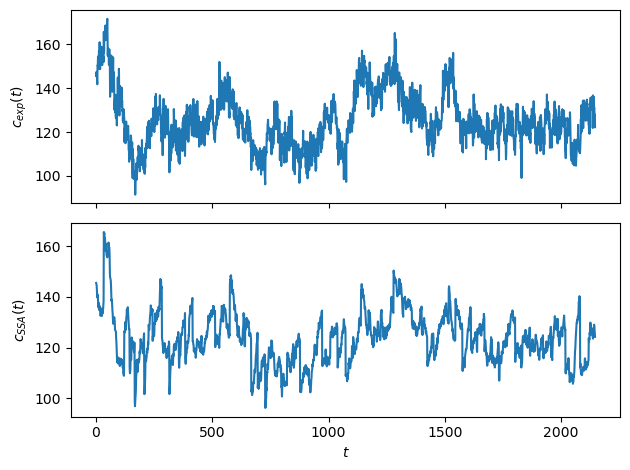

  0.013868 seconds (62.07 k allocations: 5.214 MiB)


In [92]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = single[2][1:length(single[2])]; expt_c = conc_all_lins[1][1:length(single[2])];

using LaTeXStrings;
fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

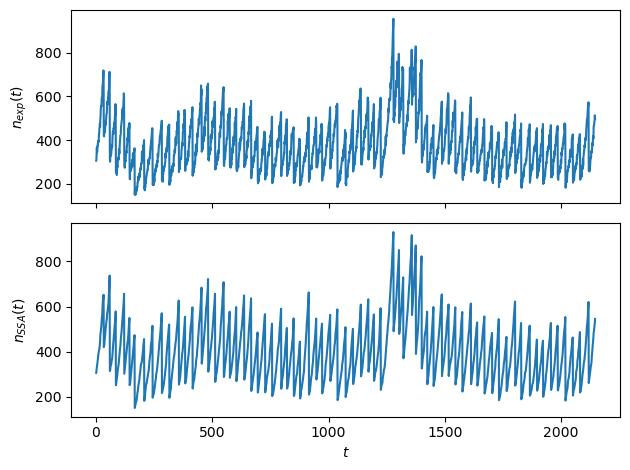

  0.016427 seconds (62.44 k allocations: 5.248 MiB)


In [84]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
nums_ssa_1 = single[1][1:length(single[2])]; expt_n = num_all_lins[1][1:length(single[1])];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"n_{exp}(t)"); axs[2].set_ylabel(L"n_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_n),step=1),expt_n); axs[2].plot(range(1,length(nums_ssa_1),step=1),nums_ssa_1);

Hmmm... Looks like an okay realisation for some SSA trajectories. Later we will perform the KS test between molecule number and concentration trajectories to assess the likelihood that the trajectories come from the same underlying distribution.

Let's perform these inferences again to test the robustness of the results.

┌ Info: GpABC rejection simulation. ϵ = 5000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 2500.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 1250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 16/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 40/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 62/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 85/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 105/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Inf

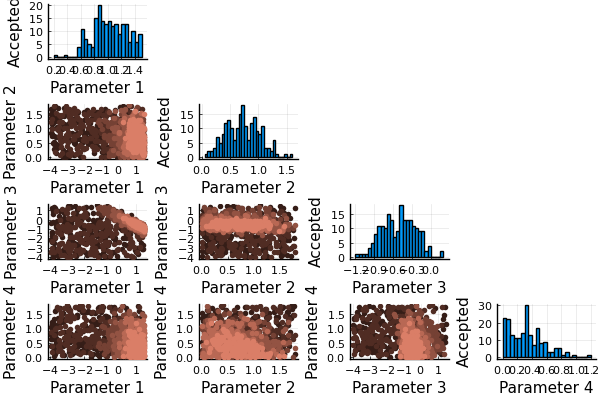

In [85]:
n_particles = 200;
threshold_schedule = [5000.0, 2500.0, 1250.0, 1000.0, 750.0, 500.0];
reference_data_c = conc_all_lins[1][1:length(single[2])];
ref_data_form = convert(Array{Float64,2},transpose(reference_data_c)); # convert ref data to the correct form.

priors = [Uniform(-4.0, 1.5), Uniform(0.0, 1.8), Uniform(-4.0, 1.5),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(ref_data_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    max_iter = convert(Int,5E4))


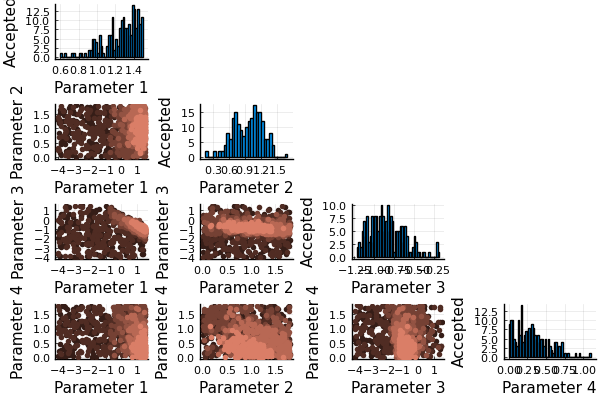

In [91]:
# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67"]#,"#E57053","#E75935"]#,"#E84D26"]#,"#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

Store the median values from the final posteriors in order $\{\alpha_0,\alpha_1,\beta_0,\beta_1\}$.

In [86]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  1.2989785449061708
  0.9867731330300324
 -0.8656683748372623
  0.2731157154819036

## Summary of results

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$ and degradation rate $d = 0$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Let's see the inferred medians of the posterior distributions in some tables.

In [87]:
using DataFrames;

In [88]:
par_conc = convert(Array{Float64,2},transpose([pars_conc_1 pars_conc_2]));
df_conc = DataFrame(alpha_0 = par_conc[:,1], alpha_1 = par_conc[:,2], beta_0 = par_conc[:,3], beta_1 = par_conc[:,4]);

In [89]:
print(df_conc)

2×4 DataFrame
│ Row │ alpha_0 │ alpha_1  │ beta_0    │ beta_1   │
│     │ Float64 │ Float64  │ Float64   │ Float64  │
├─────┼─────────┼──────────┼───────────┼──────────┤
│ 1   │ 1.02477 │ 0.71325  │ -0.495042 │ 0.310061 │
│ 2   │ 1.29898 │ 0.986773 │ -0.865668 │ 0.273116 │